In [1]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv(r"C:\Users\shraw\OneDrive\Documents\HealthCare_NoShow_project\healthcare_noshows.csv")
print(df.info())
print(df.isnull().sum())
print(df['Showed_up'].value_counts())
df['Showed_up'].map({True: 1, False: 0})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106987 entries, 0 to 106986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       106987 non-null  float64
 1   AppointmentID   106987 non-null  int64  
 2   Gender          106987 non-null  object 
 3   ScheduledDay    106987 non-null  object 
 4   AppointmentDay  106987 non-null  object 
 5   Age             106987 non-null  int64  
 6   Neighbourhood   106987 non-null  object 
 7   Scholarship     106987 non-null  bool   
 8   Hipertension    106987 non-null  bool   
 9   Diabetes        106987 non-null  bool   
 10  Alcoholism      106987 non-null  bool   
 11  Handcap         106987 non-null  bool   
 12  SMS_received    106987 non-null  bool   
 13  Showed_up       106987 non-null  bool   
 14  Date.diff       106987 non-null  int64  
dtypes: bool(7), float64(1), int64(3), object(4)
memory usage: 7.2+ MB
None
PatientId         0
Appointment

0         1
1         1
2         1
3         1
4         1
         ..
106982    1
106983    1
106984    1
106985    1
106986    1
Name: Showed_up, Length: 106987, dtype: int64

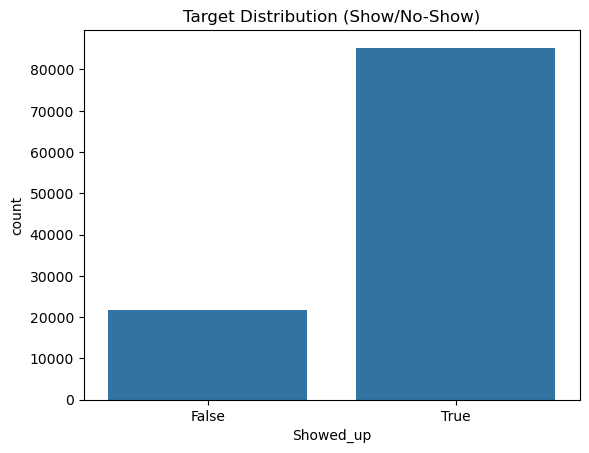

In [3]:
sns.countplot(data=df, x="Showed_up")
plt.title("Target Distribution (Show/No-Show)")
plt.show()

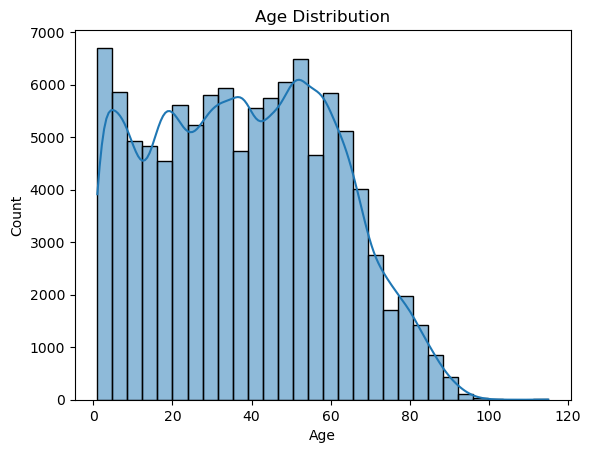

In [4]:
sns.histplot(df['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

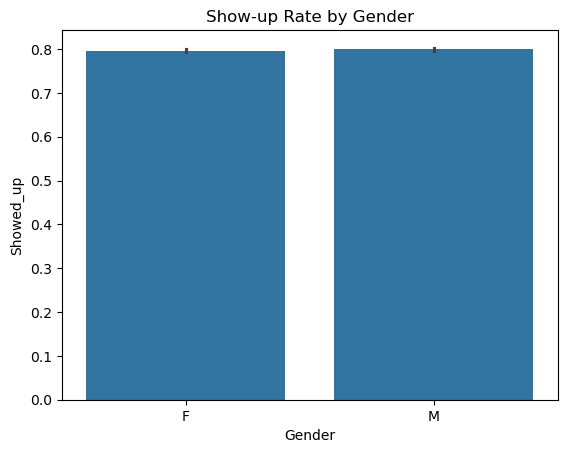

In [5]:
sns.barplot(x="Gender", y="Showed_up", data=df)
plt.title("Show-up Rate by Gender")
plt.show()

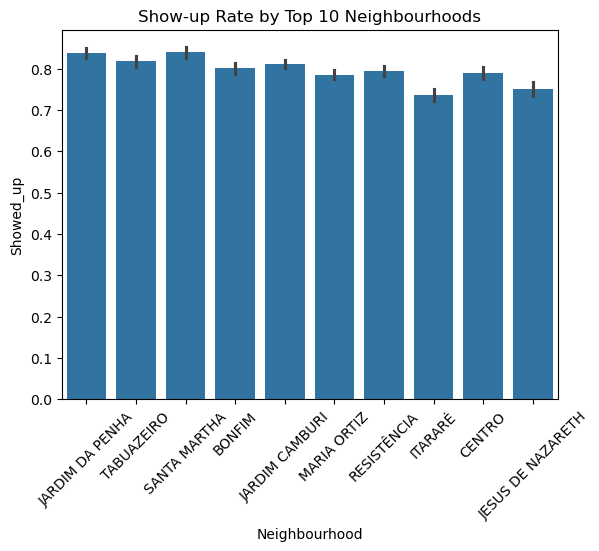

In [6]:
top_neigh = df["Neighbourhood"].value_counts().head(10).index
sns.barplot(x="Neighbourhood", y="Showed_up", data=df[df["Neighbourhood"].isin(top_neigh)])
plt.xticks(rotation=45)
plt.title("Show-up Rate by Top 10 Neighbourhoods")
plt.show()

In [7]:
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"])
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"])
df["waiting_days"] = (df["AppointmentDay"] - df["ScheduledDay"]).dt.days
df["appointment_dow"] = df["AppointmentDay"].dt.dayofweek
df["appointment_weekend"] = (df["AppointmentDay"].dt.dayofweek >= 5).astype(int)
df = df[(df["Age"] >= 0) & (df["Age"] <= 100)]
le_gender = LabelEncoder()
df["Gender"] = le_gender.fit_transform(df["Gender"])
le_neigh = LabelEncoder()
df["Neighbourhood"] = le_neigh.fit_transform(df["Neighbourhood"])
df = df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1)
print("\nCleaned data shape:", df.shape)
print(df.head())


Cleaned data shape: (106980, 14)
   Gender  Age  Neighbourhood  Scholarship  Hipertension  Diabetes  \
0       0   62             39        False          True     False   
1       1   56             39        False         False     False   
2       0   62             45        False         False     False   
3       0    8             54        False         False     False   
4       0   56             39        False          True      True   

   Alcoholism  Handcap  SMS_received  Showed_up  Date.diff  waiting_days  \
0       False    False         False       True          0             0   
1       False    False         False       True          0             0   
2       False    False         False       True          0             0   
3       False    False         False       True          0             0   
4       False    False         False       True          0             0   

   appointment_dow  appointment_weekend  
0                4                    0  
1   

In [8]:
df.to_csv("cleansed_appointments.csv", index=False)
print("Cleansed dataset exported as 'cleansed_appointments.csv'")

Cleansed dataset exported as 'cleansed_appointments.csv'


In [9]:
X = df.drop("Showed_up", axis=1)
y = df["Showed_up"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]
print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


=== Random Forest Report ===
              precision    recall  f1-score   support

       False       0.39      0.21      0.27      4335
        True       0.82      0.92      0.87     17061

    accuracy                           0.77     21396
   macro avg       0.61      0.56      0.57     21396
weighted avg       0.73      0.77      0.75     21396

ROC-AUC: 0.7176857286700473


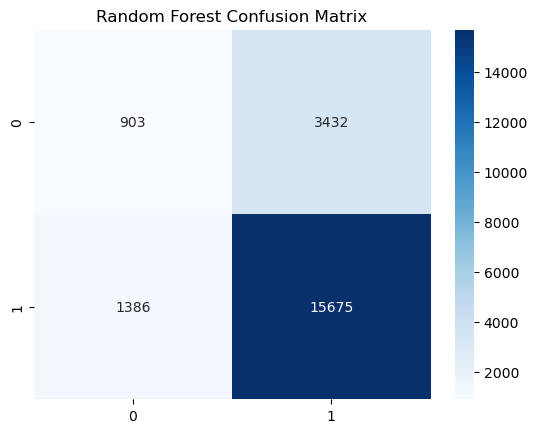

In [11]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [12]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print("\n=== XGBoost Report ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

C:\Users\shraw\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [13:17:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Report ===
              precision    recall  f1-score   support

       False       0.49      0.07      0.12      4335
        True       0.81      0.98      0.89     17061

    accuracy                           0.80     21396
   macro avg       0.65      0.52      0.50     21396
weighted avg       0.74      0.80      0.73     21396

ROC-AUC: 0.7392429917832661


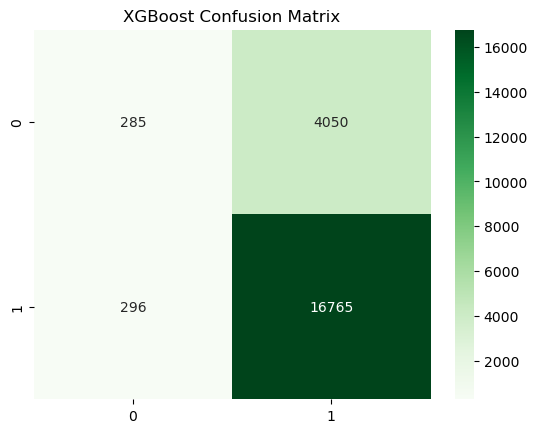

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost Confusion Matrix")
plt.show()

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)

In [15]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

y_pred_thresh = (y_prob_xgb >= optimal_threshold).astype(int)
print("\n=== XGBoost with Tuned Threshold ===")
print(classification_report(y_test, y_pred_thresh))

Optimal threshold: 0.8277697

=== XGBoost with Tuned Threshold ===
              precision    recall  f1-score   support

       False       0.31      0.86      0.45      4335
        True       0.94      0.50      0.65     17061

    accuracy                           0.57     21396
   macro avg       0.62      0.68      0.55     21396
weighted avg       0.81      0.57      0.61     21396



In [16]:
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(xgb, "xgboost_model.pkl")
print("Models saved as 'random_forest_model.pkl' and 'xgboost_model.pkl'")

Models saved as 'random_forest_model.pkl' and 'xgboost_model.pkl'
